In [1]:
%load_ext autoreload
%autoreload 2
from awesome.run.awesome_config import AwesomeConfig
from awesome.run.awesome_runner import AwesomeRunner
from awesome.util.reflection import class_name
import os
import torch

from awesome.model.convex_diffeomorphism_net import ConvexDiffeomorphismNet
from awesome.util.path_tools import get_project_root_path
from awesome.util.logging import basic_config
from awesome.dataset.awesome_dataset import AwesomeDataset
from awesome.dataset.fbms_sequence_dataset import FBMSSequenceDataset
from awesome.measures.fbms_joint_loss import FBMSJointLoss
from awesome.model.unet import UNet
from awesome.measures.weighted_loss import WeightedLoss
from awesome.measures.se import SE
from awesome.measures.unaries_conversion_loss import UnariesConversionLoss
from typing import Literal

basic_config()

os.chdir(get_project_root_path()) # Beeing in the root directory of the project is important for the relative paths to work consistently

D:\projects\AWESOME\awesome\agent\torch_agent.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:

xytype = "edge"
dataset_kind = "train"
dataset = "bear01"
all_frames = True
subset = 0 #slice(0, 5)
segmentation_model_switch: Literal["original", "retrain", "retrain_xy"] = "original"


segmentation_model_state_dict_path = None
if segmentation_model_switch == "original":
    segmentation_model_state_dict_path = f"./data/checkpoints/labels_with_uncertainty_flownet2_based/model_{dataset}_unet.pth"
elif segmentation_model_switch == "retrain":
    segmentation_model_state_dict_path = f"./data/checkpoints/refit_unet_uncertainty/23_11_13/model_{dataset}_unet.pth"
elif segmentation_model_switch == "retrain_xy":
    segmentation_model_state_dict_path = f"./data/checkpoints/refit_spatial_unet_uncertainty/23_11_13/model_{dataset}_unet.pth"
else:
    raise ValueError(f"Unknown segmentation_model_switch: {segmentation_model_switch}")
image_channel_format = "bgr" if segmentation_model_switch == "original" else "rgb"
input_channels = 4 if xytype == "edge" else 6
prior_criterion = UnariesConversionLoss(SE(reduction="mean"))

data_path = f"./data/local_datasets/FBMS-59/{dataset_kind}/{dataset}"

real_dataset = FBMSSequenceDataset(
                    dataset_path=data_path,
                    weak_labels_dir = "weak_labels/labels_with_uncertainty_flownet2_based",
                    processed_weak_labels_dir = "weak_labels/labels_with_uncertainty_flownet2_based/processed",
                    confidence_dir= "weak_labels/labels_with_uncertainty_flownet2_based/",
                    do_weak_label_preprocessing=True,
                    do_uncertainty_label_flip=True,
                    test_weak_label_integrity=False,
                    all_frames=True,
                )
data_path = f"./data/local_datasets/FBMS-59/{dataset_kind}/{dataset}"
cfg = AwesomeConfig(
        name_experiment=f"UNET+{dataset}+{xytype}+diffeo+only_prior+",
        dataset_type=class_name(AwesomeDataset),
        dataset_args={
            "dataset": real_dataset,
            "xytype": xytype,
            "feature_dir": f"{data_path}/Feat",
            "dimension": "3d", # 2d for fcnet
            "mode": "model_input",
            "model_input_requires_grad": False,
            "batch_size": 1,
            "split_ratio": 1,
            "shuffle_in_dataloader": False,
            "image_channel_format": image_channel_format,
            "do_image_blurring": True,
            "subset": subset
        },
        segmentation_model_type=class_name(UNet),
        segmentation_model_args={
            'in_chn': input_channels,
        },
        segmentation_training_mode='multi',
        segmentation_model_state_dict_path=segmentation_model_state_dict_path, # Path to the pretrained model
        use_segmentation_output_inversion=True,
        use_prior_model=True,
        prior_model_args=dict(
            n_hidden=130,
            n_hidden_layers=2,
            diffeo_args=dict(
                num_coupling=6,
                width=130,
                backbone="normal_block"
            ),
        ),
        prior_model_type=class_name(ConvexDiffeomorphismNet),
        loss_type=class_name(FBMSJointLoss),
        loss_args={
            "criterion": WeightedLoss(torch.nn.BCELoss(), mode="sssdms", noneclass=2),
            "alpha": 1,
            "beta": 1,
        },
        use_extra_penalty_hook=False, # Panalty hook for the panalty term that models output should match
        #extra_penalty_after_n_epochs=1,
        #use_reduce_lr_in_extra_penalty_hook=False,
        use_lr_on_plateau_scheduler=False,
        use_binary_classification=True, 
        num_epochs=100,
        device="cuda",
        dtype=str(torch.float32),
        runs_path="./runs/fbms_local/unet/comparison_path_nets",
        optimizer_args={
            "lr": 0.003,
            "betas": (0.9, 0.999),
            "eps": 1e-08,
            "amsgrad": False
        },
        use_progress_bar=True,
        semantic_soft_segmentation_code_dir="../siggraph/",
        semantic_soft_segmentation_model_checkpoint_dir="./data/sss_checkpoint/model",
        plot_indices_during_training_nth_epoch=20,
        plot_indices_during_training=real_dataset.get_ground_truth_indices(),
        agent_args=dict(
             do_pretraining=True,
             pretrain_only=True, 
             force_pretrain=True,
             #pretrain_state_path=f"./data/checkpoints/pretrain_states/model_{dataset}_unet_spatial_{all_frames}_{subset}.pth",
             pretrain_args=dict(
                 lr=0.001,
                 use_logger=True,
                 num_epochs=2000,
                 proper_prior_fit_retrys=1,
             )
        ),
        #output_folder="./runs/fbms_local/unet/TestUnet/",
    )
cfg.save_to_file(f"./config/{cfg.name_experiment}.yaml", override=True, no_uuid=True)

'./config/UNET+bear01+edge+diffeo+only_prior+.yaml'

In [9]:
runner = AwesomeRunner(cfg)
runner.build()
runner.store_config()

2024-01-09:15:58:20.327 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\unet\comparison_path_nets\UNET+bear01+edge+diffeo+only_prior+_24_01_09_15_58_20


'./runs/fbms_local/unet/comparison_path_nets\\UNET+bear01+edge+diffeo+only_prior+_24_01_09_15_58_20\\init_cfg_awesome_config.yaml'

In [10]:
#runner.config.num_epochs = 2000
runner.train()

2024-01-09:15:58:27.283 INFO     [torch_agent.py:581] Starting pretraining...


Pretraining images:   0%|          | 0/1 [00:00<?, ?it/s]

Image 1: Pretraining:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-09:16:02:16.946 INFO     [convex_diffeomorphism_net.py:438] Proper prior fit on image index: 0 got metric: 0.8793451189994812.
2024-01-09:16:02:16.975 INFO     [torch_agent.py:595] Pretrain state saved to ./runs/fbms_local/unet/comparison_path_nets\UNET+bear01+edge+diffeo+only_prior+_24_01_09_15_58_20\pretrain_state.pth


Computing metrics...:   0%|          | 0/1 [00:00<?, ?it/s]

PicklingError: Can't pickle <class 'awesome.model.convex_diffeomorphism_net.ConvexDiffeomorphismNet'>: it's not the same object as awesome.model.convex_diffeomorphism_net.ConvexDiffeomorphismNet

KeyError: 19

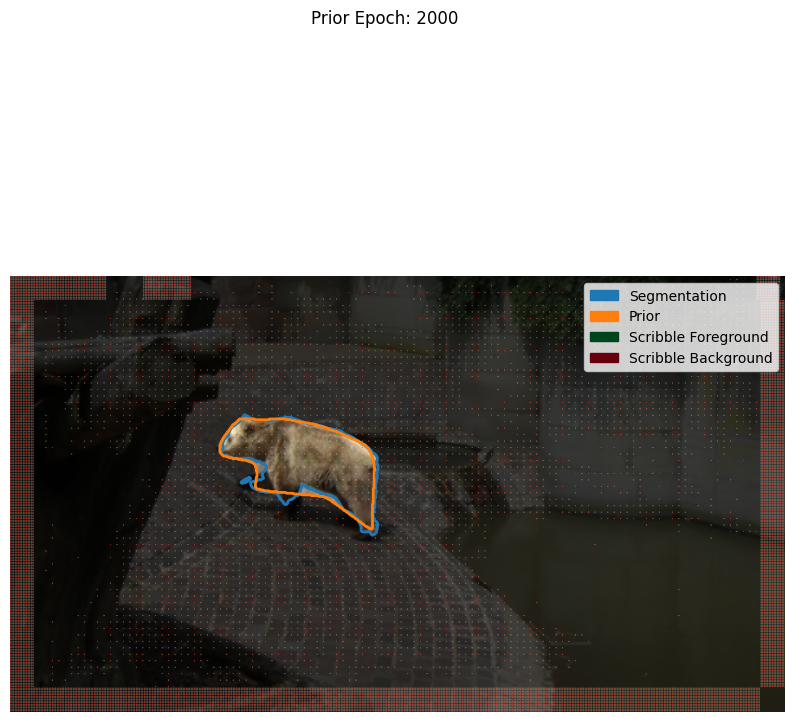

In [7]:
from awesome.run.functions import get_result, split_model_result, plot_image_scribbles
import matplotlib.pyplot as plt

index = 0

model = runner.agent._get_model()
dataloader = runner.agent.training_dataset
model_gets_targets = runner.agent.model_gets_targets

indices = [0, 19] #len(dataloader)
for i in range(len(dataloader)):
    res, ground_truth, img, fg, bg = get_result(model, dataloader, i, model_gets_targets=model_gets_targets)
    res = split_model_result(res, model, dataloader, img)
    res_prior = res.get("prior", None)
    res_pred = res["segmentation"]
    boxes = res.get("boxes", None)
    labels = res.get("labels", None)

    p = os.path.join(runner.agent.agent_folder, "pretrain_priors")
    os.makedirs(p, exist_ok=True)

    iterations = 2000
    fig = plot_image_scribbles(image=img,
                        inference_result=res_pred,
                        foreground_mask=fg,
                        background_mask=bg,
                        prior_result=res_prior,
                        save=True,
                        path=os.path.join(p, f"prior_{i}_{iterations}.png"),
                        size=10,
                        title=f"Prior Epoch: {iterations}", open=True)
    display(fig)
    plt.close(fig)


In [ ]:
1e-2 * torch.randn(5)

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
from awesome.run.transforms2d import component_scale_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)
lin = torch.nn.Linear(2, 2, bias=False)

#lin.weight.data = component_scale_matrix(x=0.5, y=0.5)[:2, :2]

x = torch.arange(1, 2.)
y = torch.arange(1, 2.)
xx, yy = torch.meshgrid(x, y)

xx_shifted, yy_shifted = xx + 0.5, yy + 0.5

xy = torch.stack([xx.flatten(), yy.flatten()], dim=1)

xy_shifted = torch.stack([xx_shifted.flatten(), yy_shifted.flatten()], dim=1)


with torch.no_grad():
    xy_transf = lin(xy)

X = np.hstack((xy_shifted.numpy(), np.ones((xy_shifted.shape[0], 1))))
theta = np.linalg.pinv(X.T @ X) @ (X.T @ xy_transf.numpy())

lin_new = torch.nn.Linear(2, 2, bias=True)
lin_new.weight.data = torch.tensor(theta[:2, :].T, dtype=torch.float32)
lin_new.bias.data = torch.tensor(theta[2, :], dtype=torch.float32)

with torch.no_grad():
    xy_shifted_transf = lin_new(xy_shifted)


In [ ]:

plt.close("all")
fig, ax = plt.subplots(1, 1)
p1 = ax.plot(xy[:, 0], xy[:, 1], "o", label="Original")
p1 = ax.plot(xy_shifted[:, 0], xy_shifted[:, 1], "o", label="Shifted")
p2 = ax.plot(xy_transf[:, 0], xy_transf[:, 1], "o", label="Transformed")
p2 = ax.plot(xy_shifted_transf[:, 0], xy_shifted_transf[:, 1], ".", label="Shifted Transformed")

plt.legend()
fig

In [ ]:
model = runner.agent._get_model()
prior_model = model.prior_module
state = prior_model.state_dict()

torch.save(state, "./temp/bear01_1_prior.pth")

In [ ]:
model = ConvexDiffeomorphismNet(130, 1, 4, 130)
state = torch.load("./temp/bear01_1_prior.pth", map_location="cpu")
model.load_state_dict(state)


In [ ]:
from awesome.dataset.transformator import Transformator
import torch
grid = Transformator.get_positional_matrices(960, 540)

with torch.no_grad():
    out = torch.sigmoid(model(grid[None, ...]))

plt.figure()
plt.imshow(out[0, 0, ...].numpy() < 0.5)
plt.show()

In [ ]:

y_center, x_center = grid.shape[1] // 2, grid.shape[2] // 2

center = grid[:, y_center, x_center]
center_2 = grid[:, y_center, x_center-3]
center_3 = grid[:, y_center-3, x_center]

center_right = grid[:, y_center, x_center + 50]
center_right_2 = grid[:, y_center, x_center + 47]
center_right_3 = grid[:, y_center-3, x_center + 50]

center_points = torch.stack([center, center_2, center_3], dim=0)
shifted_points = torch.stack([center_right, center_right_2, center_right_3], dim=0)

#center_points = torch.flip(center_points, dims=[0, 1])
#shifted_points = torch.flip(shifted_points, dims=[0, 1])


# altered_model.translate(center, center_right)

# with torch.no_grad():
#     out_altered = torch.sigmoid(altered_model(grid[None, ...]))

# plt.figure()
# plt.imshow(out[0, 0, ...].numpy() < 0.5, label="Original")
# plt.imshow(out_altered[0, 0, ...].numpy() < 0.5, label="Altered")
# plt.show()

t = torch.zeros_like(grid[0])

for i in range(center_points.shape[0]):
    t[(grid[0] == center_points[i, 0]) & (grid[1] == center_points[i, 1])] = 1

for i in range(shifted_points.shape[0]):
    t[(grid[0] == shifted_points[i, 0]) & (grid[1] == shifted_points[i, 1])] = 2

plt.close("all")
plt.figure()
plt.imshow(t)
plt.xlim(x_center - 25, x_center + 75)
plt.ylim(y_center - 25, y_center + 75)
plt.show()

In [ ]:
center_right = grid[:, y_center, x_center + 50]
center_right_x, center_right_y = center_right[0], center_right[1]

In [ ]:
def _reshape(x: torch.Tensor):
    v = x.permute(0, 2, 3, 1)
    return v.reshape((v[..., :-1].numel(), v.shape[-1]))

def _reshape_back(x: torch.Tensor):
    v = x.reshape((b, h, w, -1))
    return v.permute(0, 3, 1, 2)

pixel_grid = _reshape(grid[None,...])
pixel_grid

In [ ]:
bs = pixel_grid.shape[0]
pixel_grid[(bs // 2) + int((bs // 2) * 0.5)]

In [ ]:
from awesome.run.transforms2d import component_scale_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np
model.in_features = 2
altered_model = copy.deepcopy(model)
lin = altered_model.linear

#lin.weight.data = component_scale_matrix(x=0.5, y=0.5)[:2, :2]

def _reshape(x: torch.Tensor):
    v = x.permute(0, 2, 3, 1)
    return v.reshape((v[..., :-1].numel(), v.shape[-1]))

def _reshape_back(x: torch.Tensor):
    v = x.reshape((b, h, w, -1))
    return v.permute(0, 3, 1, 2)


x = center_points
x_shifted = shifted_points

#x = torch.flip(center_points, dims=[0, 1])
#x_shifted = torch.flip(shifted_points, dims=[0, 1])

altered_model.translate_only_point(center, center_right)

with torch.no_grad():
    out_altered = torch.sigmoid(altered_model(grid[None, ...]))


foreground = (1 - (out_altered > 0.5).float()).bool()[0,0]
center_of_mass = torch.sum(torch.argwhere(foreground), dim=0) / torch.sum(foreground).to(dtype=torch.long)
center_of_mass

from awesome.run.functions import plot_mask_multi_channel, load_image
masks = torch.cat([out, out_altered], dim=1)

path = "./data/local_datasets/FBMS-59/train/bear01/bear01_0001.jpg"
img = load_image(path)

fig = plot_mask_multi_channel(img, masks[0])

fig.axes[0].plot(center_of_mass[1], center_of_mass[0], "o", color="red", markersize=5)

fig

In [ ]:
torch.unique(out_altered)

In [ ]:
torch.sum(torch.argwhere(out_altered.squeeze()), dim=0) / torch.sum(out_altered)

In [ ]:
out_altered

In [ ]:
from awesome.run.transforms2d import component_scale_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np

altered_model = copy.deepcopy(model)
lin = altered_model.linear

#lin.weight.data = component_scale_matrix(x=0.5, y=0.5)[:2, :2]

def _reshape(x: torch.Tensor):
    v = x.permute(0, 2, 3, 1)
    return v.reshape((v[..., :-1].numel(), v.shape[-1]))

def _reshape_back(x: torch.Tensor):
    v = x.reshape((b, h, w, -1))
    return v.permute(0, 3, 1, 2)


x = center_points
x_shifted = shifted_points

#x = torch.flip(center_points, dims=[0, 1])
#x_shifted = torch.flip(shifted_points, dims=[0, 1])


altered_model.translate(x, x_shifted)

with torch.no_grad():
    out_altered = torch.sigmoid(altered_model(grid[None, ...]))

from awesome.run.functions import plot_mask_multi_channel, load_image
masks = torch.cat([out, out_altered], dim=1)

path = "./data/local_datasets/FBMS-59/train/bear01/bear01_0001.jpg"
img = load_image(path)

plot_mask_multi_channel(img, masks[0])

In [ ]:
from awesome.run.functions import plot_mask_multi_channel, load_image
masks = torch.cat([out, out_altered], dim=1)

path = "./data/local_datasets/FBMS-59/train/bear01/bear01_0001.jpg"
img = load_image(path)

plot_mask_multi_channel(img, masks[0])

In [ ]:
from awesome.run.transforms2d import component_scale_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np

altered_model = copy.deepcopy(model)
lin = altered_model.linear

#lin.weight.data = component_scale_matrix(x=0.5, y=0.5)[:2, :2]

def _reshape(x: torch.Tensor):
    v = x.permute(0, 2, 3, 1)
    return v.reshape((v[..., :-1].numel(), v.shape[-1]))

def _reshape_back(x: torch.Tensor):
    v = x.reshape((b, h, w, -1))
    return v.permute(0, 3, 1, 2)


x = center_points
x_shifted = shifted_points

with torch.no_grad():
    x_transf = lin(x)

X = np.hstack((x_shifted.numpy(), np.ones((x_shifted.shape[0], 1))))
theta = np.linalg.inv(X.T @ X) @ (X.T @ x_transf.numpy())


weight = torch.tensor(theta[:-1, :].T, dtype=torch.float32)
bias = torch.tensor(theta[-1, :], dtype=torch.float32)

altered_model.linear.weight.data = weight
altered_model.linear.bias.data = bias

with torch.no_grad():
    out_altered = torch.sigmoid(altered_model(grid[None, ...]))

from awesome.run.functions import plot_mask_multi_channel, load_image
masks = torch.cat([out, out_altered], dim=1)

path = "./data/local_datasets/FBMS-59/train/bear01/bear01_0001.jpg"
img = load_image(path)

plot_mask_multi_channel(img, masks[0])


In [ ]:
masks = torch.cat([out, out_altered], dim=1)
masks.shape

In [ ]:
center_right

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p1 = ax.plot(x_2[:, 0], x_2[:, 1], 0, "o", label="Original")
p1 = ax.plot(x_shifted2[:, 0], x_shifted2[:, 1], 0, "o", label="Shifted")
p2 = ax.plot(x_transf2[:, 0], x_transf2[:, 1],  x_transf2[:, 2], "o", label="Transformed")
p2 = ax.plot(x_shifted_transf2[:, 0], x_shifted_transf2[:, 1], x_shifted_transf2[:, 2], ".", label="Shifted Transformed")

plt.legend()
fig

In [ ]:
from awesome.dataset.prior_dataset import PriorManager
from awesome.run.functions import prepare_input_eval
from awesome.util.torch import TensorUtil
model = runner.agent._get_model()
dataloader = runner.agent.training_dataset
model_gets_targets = runner.agent.model_gets_targets

device = runner.agent.device

image, ground_truth, _input, targets, fg, bg, prior_state = prepare_input_eval(dataloader, model, index)
with torch.no_grad():
    res = None
    model.eval()
    # Adding batch dimension as this would also do the batch composition
    _input_d = TensorUtil.apply_deep(_input, lambda x: x[None, ...].to(device=device))
    with PriorManager(model, prior_state, getattr(dataloader, "__prior_cache__", None)) as prior_manager:
        # Patch the output model slidely
        grid = _input[2] # Clean grid
        center = grid[:, grid.shape[1] // 2, grid.shape[2] // 2: grid.shape[2] // 2 + 2].T.to(device=device)
        center_right = grid[:, grid.shape[1] // 2, grid.shape[2] // 2 + 50: grid.shape[2] // 2 + 52].T.to(device=device)
        
        model.prior_module.translate(center, center_right)
        model_kwargs = {}
        if model_gets_targets:
            targets = TensorUtil.apply_deep(targets, lambda x: x[None, ...].to(device=device))
            model_kwargs['targets'] = targets

        if isinstance(_input_d, (tuple, list)):
            res = model(*_input_d, **model_kwargs)
        else:
            res = model(_input_d, **model_kwargs)
        res = TensorUtil.apply_deep(res, lambda x: x.detach().cpu())
    model.train()
res = split_model_result(res, model, dataloader, img)



In [ ]:

plt.close("all")
plt.figure()
plt.imshow(res["prior"][0])
#plt.imshow(res_old["prior"][0])
plt.show()

In [ ]:
res_old = res


In [ ]:
from awesome.run.transforms2d import component_scale_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np

input_dim = 2
out_dim = 3

torch.manual_seed(1)
lin = torch.nn.Linear(input_dim, out_dim, bias=True)

#lin.weight.data = component_scale_matrix(x=0.5, y=0.5)[:2, :2]

x = torch.randn(out_dim, input_dim)
x_shifted = x + 0.5

x_2 = torch.randn(5, input_dim)
x_shifted2 = x_2 + 0.5

with torch.no_grad():
    x_transf = lin(x)
    x_transf2 = lin(x_2)

X = np.hstack((x_shifted.numpy(), np.ones((x_shifted.shape[0], 1))))
theta = np.linalg.inv(X.T @ X) @ (X.T @ x_transf.numpy())

lin_new = torch.nn.Linear(input_dim, out_dim, bias=True)
lin_new.weight.data = torch.tensor(theta[:-1, :].T, dtype=torch.float32)
lin_new.bias.data = torch.tensor(theta[-1, :], dtype=torch.float32)

with torch.no_grad():
    x_shifted_transf = lin_new(x_shifted)
    x_shifted_transf2 = lin_new(x_shifted2)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p1 = ax.plot(x_2[:, 0], x_2[:, 1], 0, "o", label="Original")
p1 = ax.plot(x_shifted2[:, 0], x_shifted2[:, 1], 0, "o", label="Shifted")
p2 = ax.plot(x_transf2[:, 0], x_transf2[:, 1],  x_transf2[:, 2], "o", label="Transformed")
p2 = ax.plot(x_shifted_transf2[:, 0], x_shifted_transf2[:, 1], x_shifted_transf2[:, 2], ".", label="Shifted Transformed")

plt.legend()
fig

In [ ]:
X = np.hstack((X, np.ones((X.shape[0], 1))))
theta = np.linalg.solve(X.T @ X, X.T @ Y)

In [ ]:
xx_shifted

In [ ]:
component_transformation_matrix(x=0.5, y=0.5)

In [ ]:
from awesome.run.transforms2d import component_transformation_matrix

In [ ]:
xx.dtype

In [ ]:
torch.unique(res_prior)

In [ ]:
torch.unique(res_prior)

In [ ]:
from awesome.util.temporary_property import TemporaryProperty


with TemporaryProperty(runner.dataloader, mode="sample", return_prior=False):
    fig = runner.dataloader[0]["raw_sample"].plot_weak_labels()
    display(fig)

In [ ]:
dataloader = runner.dataloader.__dataset__
import awesome.run.functions as F
import matplotlib.pyplot as plt

index = 0

size = 10
cols = 4
fig, ax = plt.subplots(1, cols, figsize=(size * cols, size))

sample = dataloader[index]

sample.plot(ax=ax[0], labels=sample.ground_truth_object_ids)
ax[0].set_title("Ground truth")

sample.plot_weak_labels(ax=ax[1])
ax[1].set_title("Weak labels")

sample.plot_selected_weak_labels(ax=ax[2])
ax[2].set_title("Selected Weak labels")

sample.plot_selected(ax=ax[3], labels=["Foreground", "Background"])
ax[3].set_title("Selected ground truth")


mapping = sample._get_gt_object_id_weak_label_mapping()
display(mapping)
fig

## T

In [ ]:
assert False, "Stop here"
# Code for extracting the trajectories into the dataset folder
tracks_path = "data/local_datasets/FBMS-59/tracks"
dataset_dirs = "data/local_datasets/FBMS-59/test/"

import shutil

for folder in os.listdir(tracks_path):
    inner_path = "MulticutResults/pfldof0.5000004"
    complete_track_path = os.path.join(tracks_path, folder, inner_path)
    tracks_file = list(os.listdir(complete_track_path))[0]
    tracks_file_path = os.path.join(complete_track_path, tracks_file)

    target_path = os.path.join(dataset_dirs, folder, "tracks", "multicut")
    os.makedirs(target_path, exist_ok=True)
    target_file_path = os.path.join(target_path, tracks_file)
    shutil.copy(tracks_file_path, target_file_path)
